In [1]:
# import libraries

import ROOT
import numpy as np
from collections import defaultdict
import pandas as pd
from IPython.display import Image
from subprocess import call

import hax
hax.init(main_data_paths=['/project/lgrandi/tunnell/run_14/Kr83mDiffusion_Pax4.9.1/',
                          '/project/lgrandi/xenon100/archive/root/merged/xenon100/run_14_pax4.1.2/'],
         raw_data_local_path='/project/lgrandi/tunnell/')

from Kr83m_Basic import *

def atan(y, x):
    phi = np.arctan2(y, x)
    for i in range(len(phi)):
        if phi[i] < 0: 
            phi[i] += 2*np.pi
    return phi

#hax.ipython.code_hider()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def xe100_to_lyBins(df,bin_settings,peak,bin_spec_dir='Bin_Hists'):
    
    R, Z, A_r, N_phi, N_z = bin_settings
    z_width = Z / N_z
    phi_widths = []
    for n in N_phi:
        phi_widths.append(2*np.pi/n)
    
    if peak == 's10':
        s1_spec_max = 200
        s1_ene = 32.1498 # from nuclear data sheets a=83
    elif peak == 's11':
        s1_spec_max = 100
        s1_ene = 9.4051
    else:
        print('error: invalid peak')
        return()

    bin_data = defaultdict(list)


    for z_i in range(int(N_z)):
    
        z_min = z_i * z_width
        z_max = (z_i+1) * z_width
        df_z = df[ (df[peak+'z']>z_min) & (df[peak+'z']<=z_max) ]
    
        for r_i in range(len(A_r)):
        
            if r_i == 0:
                r_min = 0
            else:
                r_min = A_r[r_i-1]
            r_max = A_r[r_i]
            df_r = df_z[ ( np.sqrt(df_z[peak+'x']**2 + df_z[peak+'y']**2)>r_min )
                       & ( np.sqrt(df_z[peak+'x']**2 + df_z[peak+'y']**2)<=r_max )]
        
            for phi_i in range(N_phi[r_i]):
            
                bin_data['z_i'].append(z_i)
                bin_data['z'].append( (z_max + z_min)/2 )
                bin_data['r_i'].append(r_i)
                bin_data['r'].append( (r_max + r_min)/2 )
                bin_data['phi_i'].append(phi_i)
                
                phi_min = phi_i * phi_widths[r_i] 
                phi_max = (phi_i+1) * phi_widths[r_i] 
                bin_data['phi'].append( (phi_max + phi_min)/2 )
            
                df_phi = df_r[ (atan(df_r[peak+'y'].values, df_r[peak+'x'].values) > phi_min) 
                             & (atan(df_r[peak+'y'].values, df_r[peak+'x'].values) <= phi_max )]
            
                bin_data['N'].append(len(df_phi))
                
                
                    
                c1 = ROOT.TCanvas('','', 800, 700)
                hist = ROOT.TH1D('','', 100, 0, s1_spec_max)
                for i in range(len(df_phi[peak+'Area'])):
                    hist.Fill(df_phi[peak+'Area'].values[i])
                hist.SetTitle(peak+' Spectrum: \
                              %.1f < z < %.1f, %.1f < r < %.1f, %.1f < phi < %.1f,'
                              %(z_min, z_max, r_min, r_max, phi_min, phi_max))
                hist.GetXaxis().SetTitle(peak+'Area (pe)')
                hist.GetXaxis().CenterTitle()
                hist.Sumw2()
                hist.SetStats(False)
                hist.Draw()
                hist.Fit('gaus')
                fit = hist.GetFunction('gaus')
                p1 = fit.GetParameter(1)
                e1 = fit.GetParError(1)
                
                bin_data['S1AreaMean'].append(p1)
                bin_data['S1AreaMeanError'].append(e1)
                
                bin_data['ly'].append(p1/s1_ene)
                bin_data['errly'].append(e1/s1_ene)
                
                if bin_spec_dir != 'none':
                    
                    call('mkdir '+bin_spec_dir,shell=True)
                
                    chi2 = fit.GetChisquare()
                    ndf = fit.GetNDF()
                    p0 = fit.GetParameter(0)
                    e0 = fit.GetParError(0)
                    p2 = fit.GetParameter(2)
                    e2 = fit.GetParError(2)
            
                    pt = ROOT.TPaveText(.58, .68, .88, .88, 'NDC')
                    pt.AddText('Entries = %d'%len(df_phi))
                    pt.AddText('#mu = %1.3f #pm %1.3f'%(p1, e1))
                    pt.AddText('#sigma = %1.3f #pm %1.3f' %(p2, e2))
                    pt.AddText('Amplitude = %1.3f #pm %1.3f' %(p0, e0))
                    pt.AddText('#chi^{2}/NDF = %1.3f/%1.3f' %(chi2, ndf))
            
                    pt.Draw()
            
                    c1.Print(bin_spec_dir+'/f_'+peak+'_z%d_r%d_phi%d.png' %(z_i, r_i, phi_i))
                
                c1.Clear()
                hist.Delete()
                
    return bin_data

In [3]:
def lyBins_to_txt(bin_data,out_file):
    
    f = open(out_file, 'w')
    header = 'z    t    r    zmid    tmid    rmid    ly    errly\n'
    f.write(header)
    
    for i in range(len(bin_data['z'])):
        bin_values = (str(bin_data['z_i'][i])+'    '+str(bin_data['phi_i'][i])+'    '+str(bin_data['r_i'][i])+'    '
                    +str(bin_data['z'][i])+'    '+str(bin_data['phi'][i])+'    '+str(bin_data['r'][i])+'    '
                    +str(bin_data['ly'][i])+'    '+str(bin_data['errly'][i])+'\n')
        f.write(bin_values)
                        
    f.close()    

In [4]:
# datasets processed by pax_4.1.2
datasets = ['xe100_150413_1839','xe100_150414_1535',
               'xe100_150419_1611','xe100_150420_0304',
               'xe100_150420_1809']

# load minitrees
# throws error when building minitrees for many datasets, I built them one by one

data = hax.minitrees.load(datasets, treemakers=Kr83m_Basic)
data = data[data['s10Time']>=0] # remove NaNs

Found minitree at ./xe100_150413_1839_Kr83m_Basic.root
Found minitree at ./xe100_150414_1535_Kr83m_Basic.root
Found minitree at ./xe100_150419_1611_Kr83m_Basic.root
Found minitree at ./xe100_150420_0304_Kr83m_Basic.root
Found minitree at ./xe100_150420_1809_Kr83m_Basic.root


In [5]:
# Fill bin data from Kr83m event data

df = data[ (data['s10Coin']>=3) & (data['s20Coin']>=4) & (data['s11Coin']>=2) & 
           ((data['s21Area']==0) | (data['s21Area']>=200)) & (data['s11Area']>7) &
           (data['s11Time']-data['s10Time']>0)]

R = 15.25
Z = 30.3
A_r = [R/5, 2*R/5, 3*R/5, 4*R/5, R]
N_phi = [10, 15, 20, 40, 60]
N_z = 10.0
bin_settings = [R,Z,A_r,N_phi,N_z]

bin_data = xe100_to_lyBins(df,bin_settings,'s11',bin_spec_dir='Bin_Hists_s11')

In [6]:
# Create ly map file

lyBins_to_txt(bin_data,'s1xyzmap-20160527-pax.txt')

In [56]:
# Read .txt file to plot

def txt_to_plot(file_name, peak, diff = False):
    if not isinstance(file_name, str): 
        print ('Error: arg must be str')
    else:
        fl = open(file_name, 'r')
        ls = fl.readline().strip().split(" ")
        labels = []
        for item in ls:
            if item != '':
                labels.append(item)
        fl.close()
        bin_array = np.loadtxt(file_name, skiprows=1)
        bin_array_new = bin_array.tolist()
        bin_array_new.sort(key = lambda x: (float(x[0]), float(x[2]), float(x[1])))
       
        for j in range(len(bin_array_new)):
            
            if bin_array_new[j][3] < -10:
                bin_array_new[j][3] = bin_array_new[j][3] / 10
                bin_array_new[j][5] = bin_array_new[j][5] / 10
            
            if bin_array_new[j][3] < 0:
                bin_array_new[j][3] = bin_array_new[j][3] * -1

        bin_dict = defaultdict(list)
        for i in range(len(bin_array_new[0])):
            for j in range(len(bin_array_new)):
                bin_dict[labels[i]].append(bin_array_new[j][i])
                
                
                
        df = pd.DataFrame(bin_dict)
        dummyH_list=[]

        c1 = ROOT.TCanvas( '','', 2400, 3200 ) 
        ROOT.gStyle.SetOptStat(0)
        c1.Divide(3,4,0.02,0.02)

        z_hists = []
        
        max_ly = max(df['ly'])
        min_ly = min(df['ly'])

        for z_i in range(int(N_z)):

            dummyH_list.append(ROOT.TH2D("","",100,-R,R,100,-R,R))

            df_new = df[ df['z'] == z_i ]
            hists = []
            for r_i in range(len(A_r)):
                hists.append(ROOT.TH2D('','', N_phi[r_i], 0, 2*np.pi, len(A_r), 0, R ))
                df_newer = df_new[ df_new['r'] == r_i ]
                for i in range(len(df_newer)):
                    hists[r_i].Fill(df_newer['tmid'].values[i], df_newer['rmid'].values[i],
                                    df_newer['ly'].values[i] )

            z_hists.append(hists)

            c1.cd(z_i+1)

            dummyH_list[z_i].Draw('colz')
            dummyH_list[z_i].SetTitle("%.2fcm < z < %.2fcm" %(z_i*3.03, (z_i+1)*3.03 ))
            dummyH_list[z_i].GetZaxis().SetTitle("<s1Area>")
            dummyH_list[z_i].GetXaxis().SetTitle("x position [cm]")
            dummyH_list[z_i].GetXaxis().CenterTitle()
            dummyH_list[z_i].GetYaxis().SetTitle("y position [cm]")
            dummyH_list[z_i].GetYaxis().CenterTitle()

        #     c1.SetTopMargin(0.2)
            c1.SetRightMargin(0.2)

            for i in range(len(z_hists[z_i])):

                z_hists[z_i][i].GetZaxis().SetRangeUser(0, max_ly)
                if diff:
                    z_hists[z_i][i].GetZaxis().SetTitle("(pax_ly - xerawdp_ly)^{2} [pe/keV]")
                else:
                    z_hists[z_i][i].GetZaxis().SetTitle(peak + " ly [pe/keV]")
                z_hists[z_i][i].GetZaxis().SetTitleOffset(1.8)
                z_hists[z_i][i].Draw('pol colz a same') 

        c1.Print(file_name.split('.')[0] + '_' + peak + '.png')
        c1.Clear()
        return
  
        

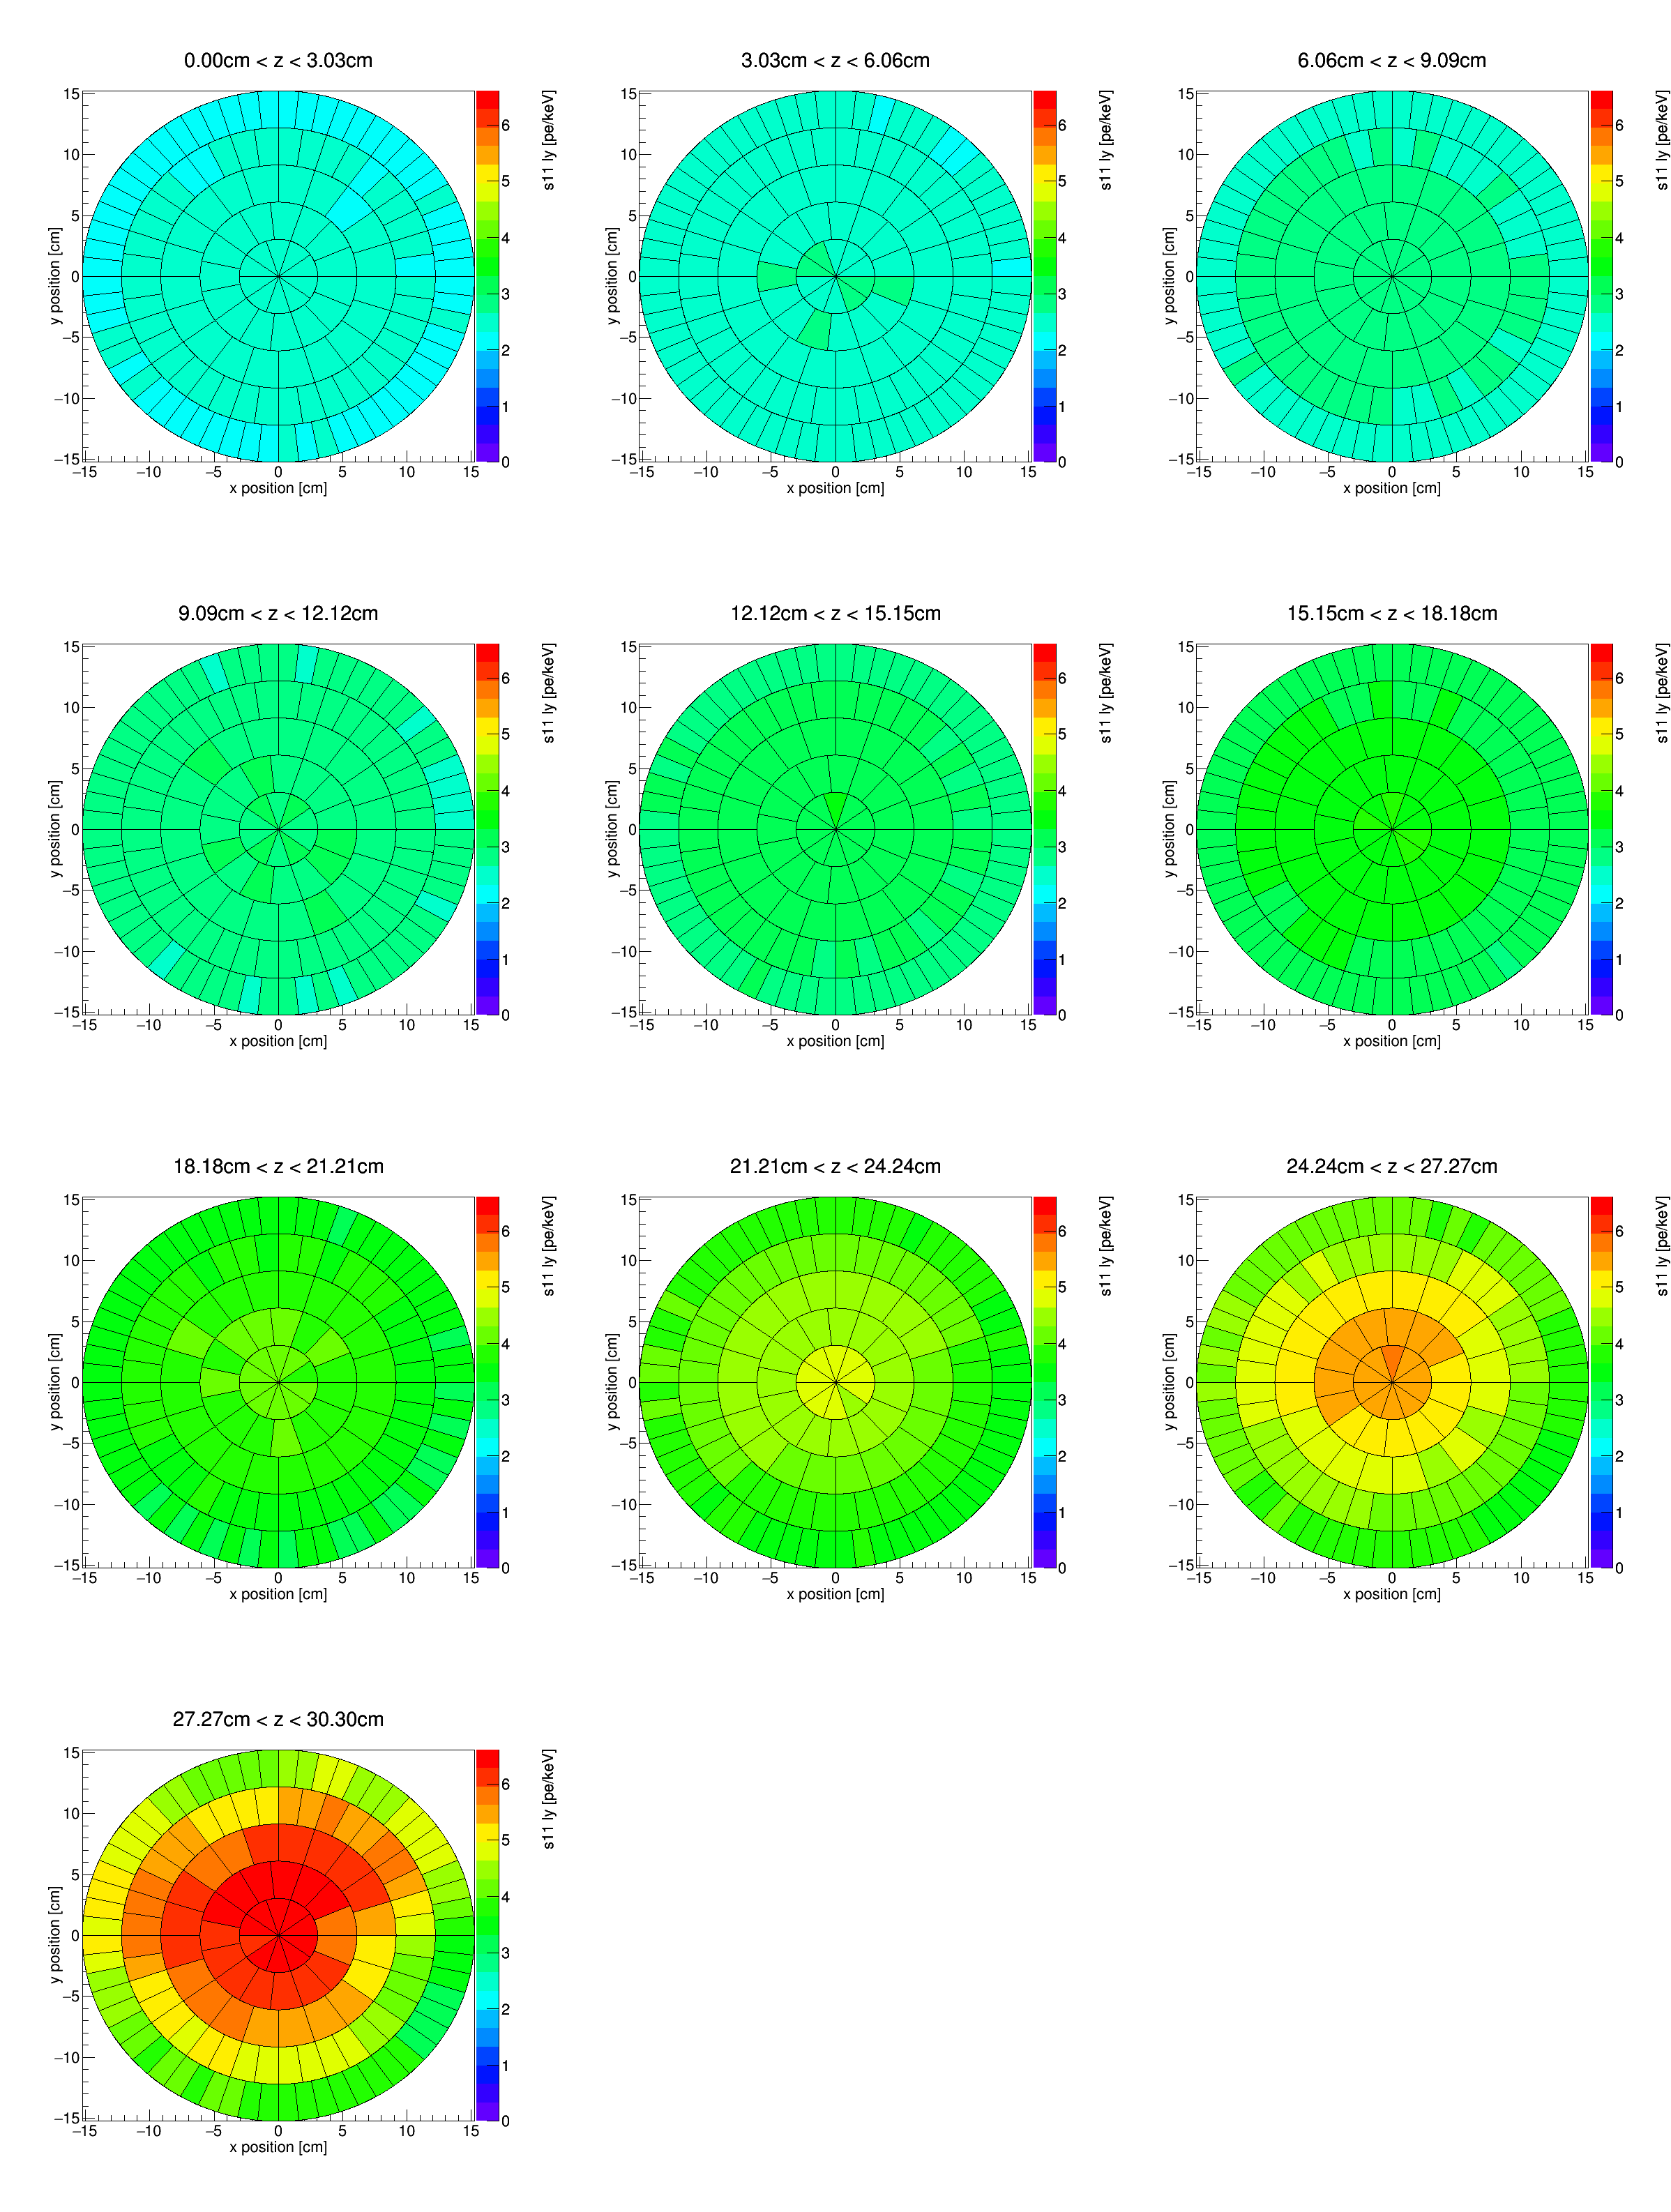

In [57]:
# Richard's maps (absolute light yield)

txt_to_plot('richards_file.txt', 's11')
Image(filename='richards_file_s11.png')

In [53]:
def difference_in_ly(file1, file2):
    
    # GIVES SQUARE OF DIFFERENCES
    
    if not isinstance(file1, str) or not isinstance(file2, str): 
        print ('Error: args must be str type')
        
    else:
        
        # read first file
        
        fl = open(file1, 'r')
        ls = fl.readline().strip().split(" ")
        labels = []
        for item in ls:
            if item != '':
                labels.append(item)
        fl.close()
        bin_array = np.loadtxt(file1, skiprows=1)
        bin_array_new_1 = bin_array.tolist()
        bin_array_new_1.sort(key = lambda x: (float(x[0]), float(x[2]), float(x[1])))
       
        for j in range(len(bin_array_new_1)):
            
            if bin_array_new_1[j][3] < -10:
                bin_array_new_1[j][3] = bin_array_new_1[j][3] / 10
                bin_array_new_1[j][5] = bin_array_new_1[j][5] / 10
            
            if bin_array_new_1[j][3] < 0:
                bin_array_new_1[j][3] = bin_array_new_1[j][3] * -1

        bin_dict_1 = defaultdict(list)
        for i in range(len(bin_array_new_1[0])):
            for j in range(len(bin_array_new_1)):
                bin_dict_1[labels[i]].append(bin_array_new_1[j][i])
                
        # read second file
        
        fl = open(file2, 'r')
        ls = fl.readline().strip().split(" ")
        labels = []
        for item in ls:
            if item != '':
                labels.append(item)
        fl.close()
        bin_array = np.loadtxt(file2, skiprows=1)
        bin_array_new_2 = bin_array.tolist()
        bin_array_new_2.sort(key = lambda x: (float(x[0]), float(x[2]), float(x[1])))
       
        for j in range(len(bin_array_new_2)):
            
            if bin_array_new_2[j][3] < -10:
                bin_array_new_2[j][3] = bin_array_new_2[j][3] / 10
                bin_array_new_2[j][5] = bin_array_new_2[j][5] / 10
            
            if bin_array_new_2[j][3] < 0:
                bin_array_new_2[j][3] = bin_array_new_2[j][3] * -1

        bin_dict_2 = defaultdict(list)
        for i in range(len(bin_array_new_2[0])):
            for j in range(len(bin_array_new_2)):
                bin_dict_2[labels[i]].append(bin_array_new_2[j][i])
    
        
        
        f = open('difference_in_ly.txt', 'w')
        f.write('z    t    r    zmid    tmid    rmid    ly    errly    sq_dif')
        

        for i in range(len(bin_dict_1['z'])):
            f.write('\n' + str(bin_dict_1['z'][i])+'    '+str(bin_dict_1['t'][i])+'    '+str(bin_dict_1['r'][i])+'    '
                        +str(bin_dict_1['zmid'][i])+'    '+str(bin_dict_1['tmid'][i])+'    '+str(bin_dict_1['rmid'][i])+'    '
                        +str((bin_dict_1['ly'][i]-bin_dict_2['ly'][i])**2))
        f.close()    
        
        
        

In [54]:
# make diff file
difference_in_ly('richards_file.txt', 's1xyzmap-20160527-pax.txt')

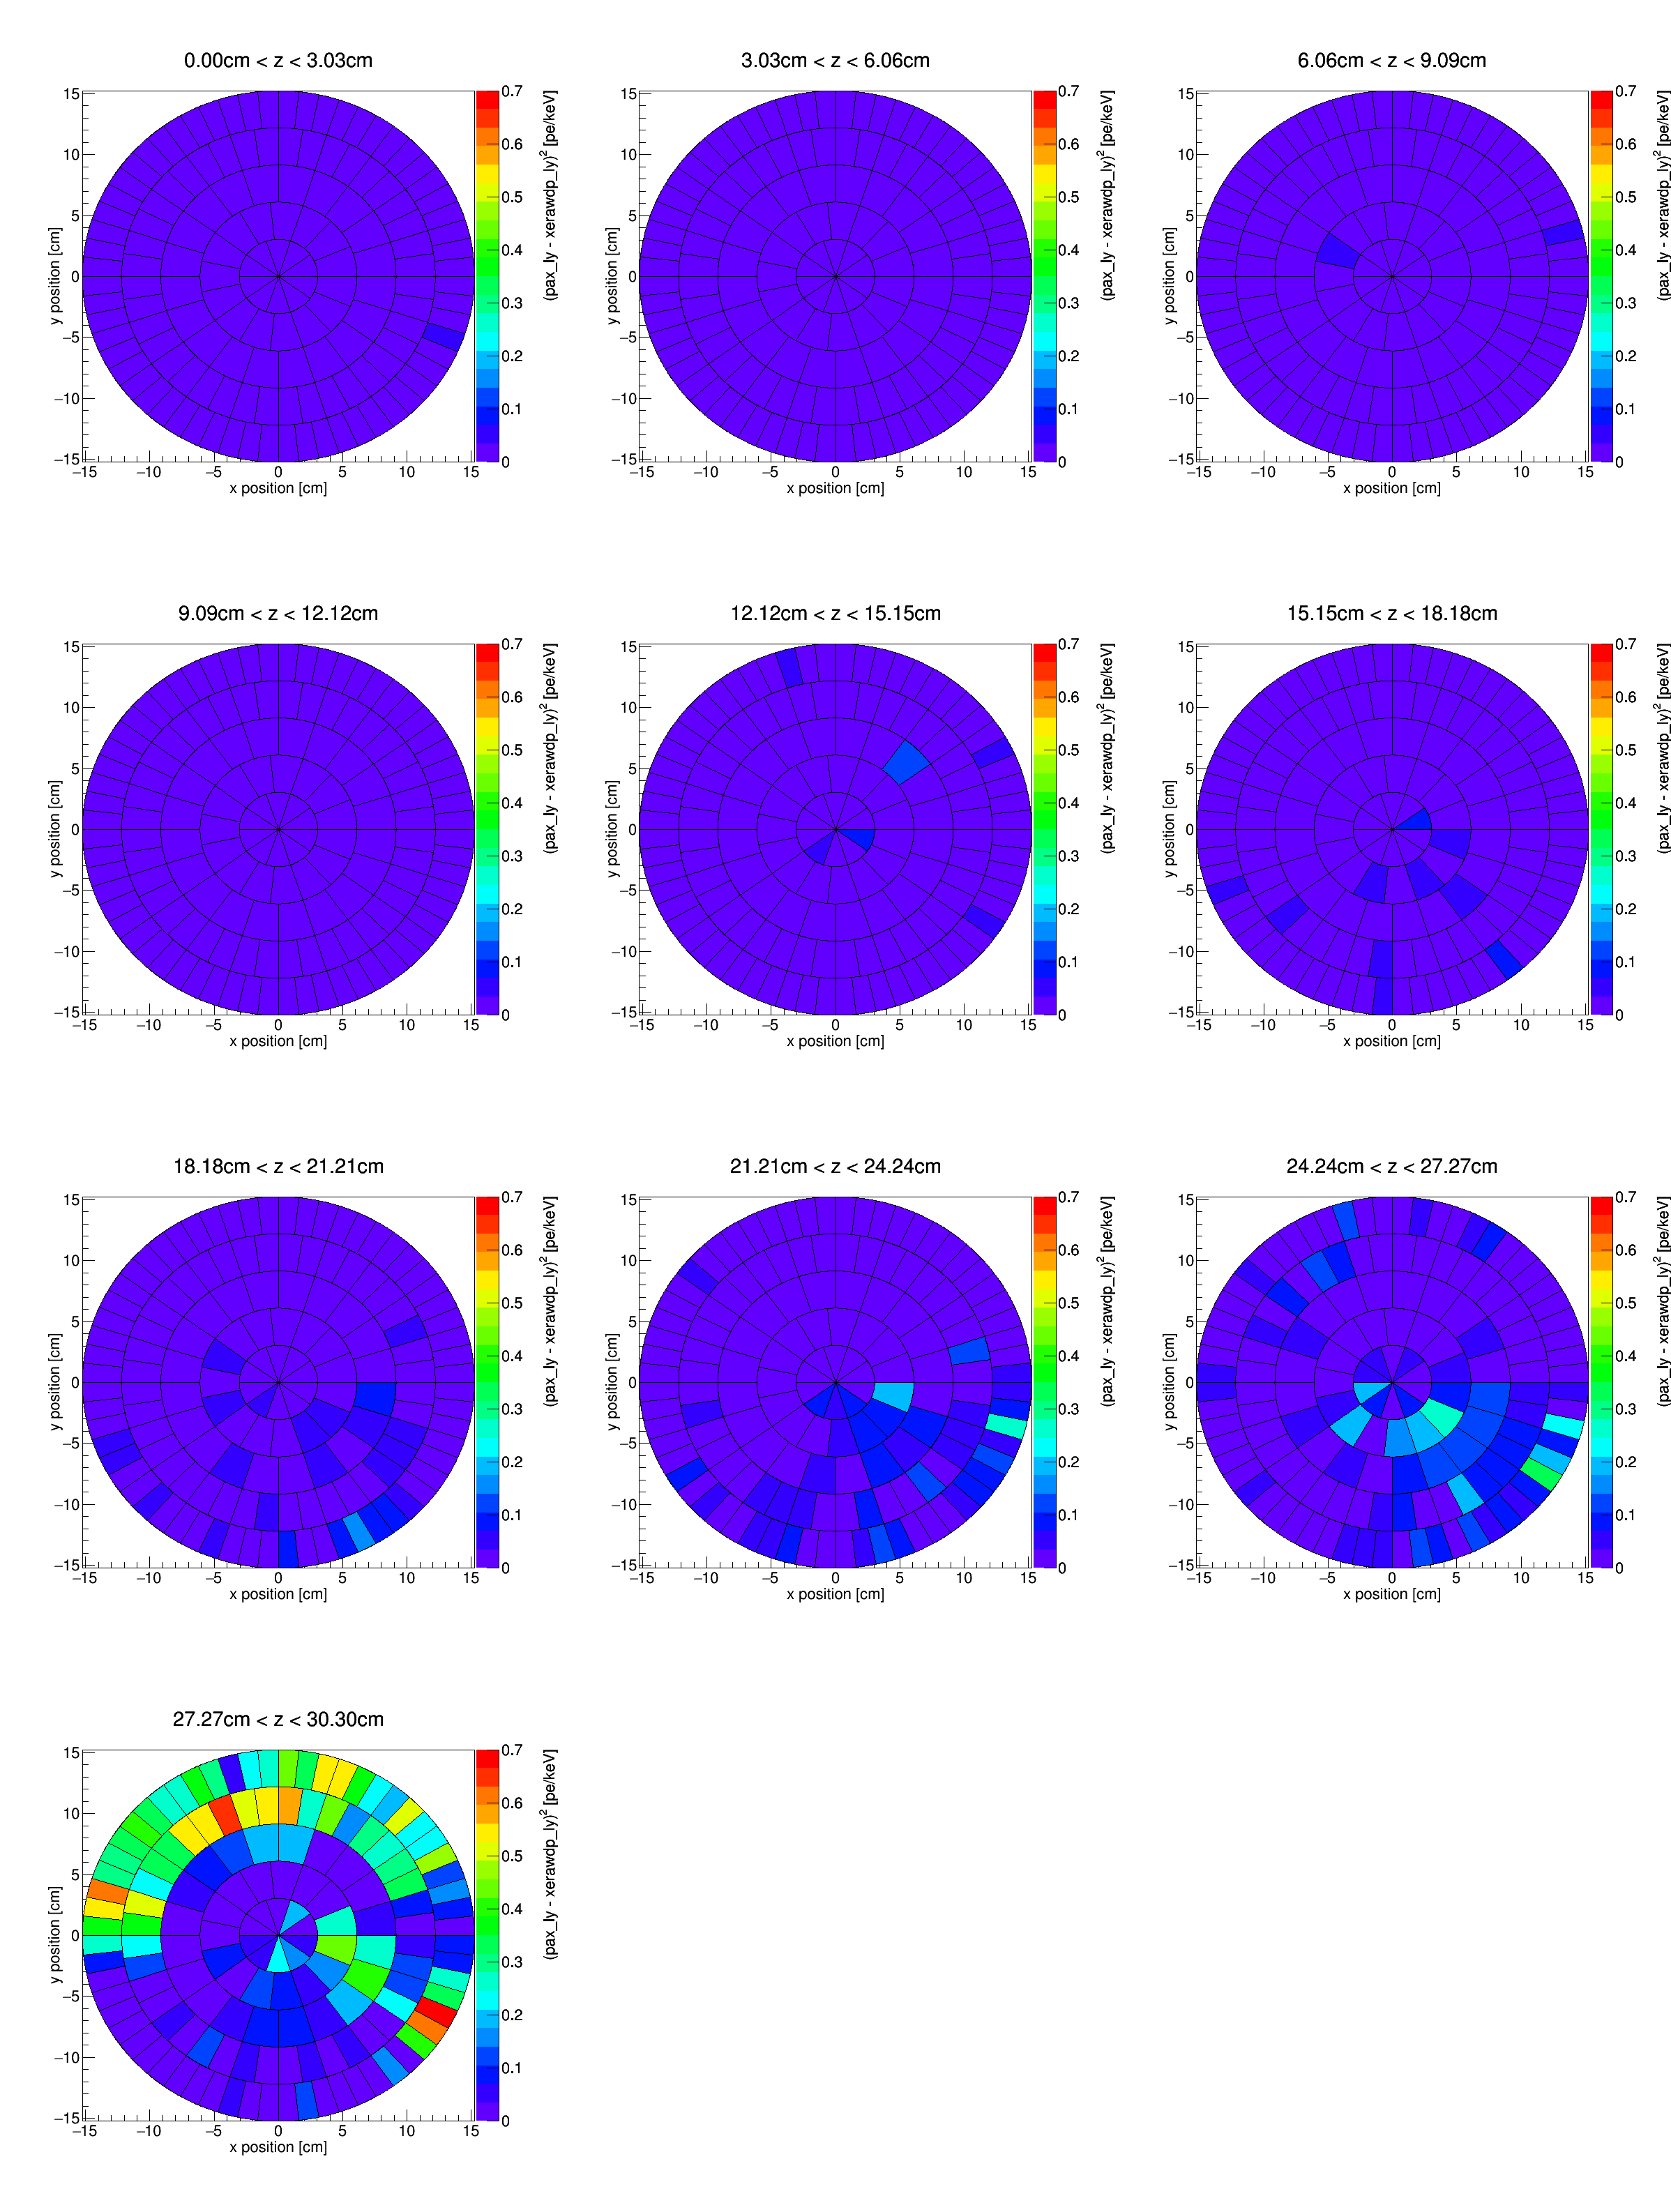

In [58]:
# plot ly difference
txt_to_plot('difference_in_ly.txt', 's11', diff = True)
Image(filename='difference_in_ly_s11.png')

In [59]:
def triple_plot(file1, file2, fileDiff):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-59-bfd51d5d29e8>, line 1)